In [1]:
# Input data
import numpy as np
from utilities import *

# test and train read
X_train_valid, Y_train_valid, list_ch_train_valid = read_data(data_path="../../../datasets/har/har-data/", 
                                                              split="train")
X_test, Y_test, list_ch_test = read_data(data_path="../../../datasets/har/har-data/", split="test")

assert list_ch_train_valid == list_ch_test, "Mistmatch in channels!"
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)

print(np.mean(Y_train_valid==0), np.mean(Y_train_valid==1), np.mean(Y_train_valid==2), 
      np.mean(Y_train_valid==3), np.mean(Y_train_valid==4), np.mean(Y_train_valid==5),
      np.mean(Y_train_valid==6), np.mean(Y_train_valid==7))

0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0


In [2]:
# Preparing input and output data
# from utilities import *

# Normalizing/standardizing the input data features
X_train_valid_norm, X_test_norm = standardize(test=X_test, train=X_train_valid)

# Onehot encoding/vectorizing the output data labels
print(np.mean((Y_train_valid).reshape(-1)==0), np.mean((Y_train_valid).reshape(-1)==1),
     np.mean((Y_train_valid).reshape(-1)==2), np.mean((Y_train_valid).reshape(-1)==3),
     np.mean((Y_train_valid).reshape(-1)==4), np.mean((Y_train_valid).reshape(-1)==5),
     np.mean((Y_train_valid).reshape(-1)==6), np.mean((Y_train_valid).reshape(-1)==7))

Y_train_valid_onehot = one_hot(labels=Y_train_valid.reshape(-1), n_class=6) 
Y_test_onehot = one_hot(labels=Y_test.reshape(-1), n_class=6) 

print(Y_train_valid_onehot.shape, Y_train_valid_onehot.dtype, 
      Y_test_onehot.shape, Y_test_onehot.dtype)

0.0 0.16675734494015235 0.1459466811751904 0.13411316648531013 0.1749183895538629 0.1868879216539717 0.1913764961915125 0.0
(7352, 6) float64 (2947, 6) float64


In [3]:
# Train and valid split
from sklearn.model_selection import train_test_split

X_train_norm, X_valid_norm, Y_train_onehot, Y_valid_onehot = train_test_split(X_train_valid_norm, 
                                                                              Y_train_valid_onehot,
                                                                              test_size=0.30)

print(X_train_norm.shape, X_valid_norm.shape, Y_train_onehot.shape, Y_valid_onehot.shape)

(5146, 128, 9) (2206, 128, 9) (5146, 6) (2206, 6)


In [4]:
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


In [5]:
## Hyperparameters
# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial
print('batch_size, seq_len, n_channels', batch_size, seq_len, n_channels)

# Output labels
n_classes = Y_train_valid.max(axis=0)
assert Y_train_valid.max(axis=0) == Y_test.max(axis=0)
print('n_classes', n_classes)

batch_size, seq_len, n_channels 51 128 9
n_classes 6


In [33]:
# Feed the data from python/numpy to tensorflow framework
# NWC or NHWC: Number, Height/Width, Channels
# print(X_train_norm.shape, X_train_norm.dtype)
# The common mistake the N or number of batches or number of input should be minimum of train, valid, or test
# obviously should be validation set since it is the smallest one then.
# The rest of other dimensions/axes/axises are all the same
# print(X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)
# print(X_train_norm.dtype, X_valid_norm.dtype, X_test_norm.dtype)
# The N should be the minimum of these three bacthes so that we can train, validate and test.
# W, Cin are the same for all training, validation, testing
N, W, Cin = X_valid_norm.shape[0], X_train_norm.shape[1], X_train_norm.shape[2]
# print(N, W, Cin)
# inputs_ = tf.placeholder(tf.float32, [N, W, Cin], name =None)
inputs_ = tf.placeholder(dtype=tf.float32, name=None, shape=[N, W, Cin])
print(inputs_.shape, inputs_.dtype)

# Channels for output or classes or dimensions for output
# print(Y_train_valid.shape, Y_train_valid.dtype)
# print(Y_train_valid.max(axis=0), Y_test.max(axis=0))
assert Y_train_valid.max(axis=0)==Y_test.max(axis=0)
# This is the class label or number from 1, ..., 6
Cout = Y_train_valid.max(axis=0)
# labels_ = tf.placeholder(tf.float32, [N, Cout], name =None)
labels_ = tf.placeholder(dtype=tf.float32, name=None, shape=[N, Cout])
print(labels_.shape, labels_.dtype)

(2206, 128, 9) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [34]:
# This is one convolution channel for example
print(inputs_.shape, inputs_.dtype)
# variable/weight shape should be based on NWC but the other way around WCN
# Width, Channels, Number of weights
Wwidth, Wchannels, Wnumber = inputs_.shape[1].value//2, inputs_.shape[2].value, inputs_.shape[2].value*2 # double up the input channels
shape = [Wwidth, Wchannels, Wnumber]
# print(shape)
# initializing the weight using normal
initial_value = tf.random_normal(dtype=inputs_.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
# Weight, variable and itsshape
Wconv = tf.Variable(dtype=inputs_.dtype, initial_value=initial_value, name=None, trainable=True)
print(Wconv.shape, Wconv.dtype)
# input shape and type as the input tensor
# convolution operation as well
Xconv = tf.nn.conv1d(data_format='NWC', filters=Wconv, name=None, padding='SAME', stride=2, use_cudnn_on_gpu=True, 
                     value=inputs_)
print(Xconv.shape, Xconv.dtype)

(2206, 128, 9) <dtype: 'float32'>
(64, 9, 18) <dtype: 'float32_ref'>
(2206, 64, 18) <dtype: 'float32'>


In [35]:
# This is one multiplication channel for example
# Flatten and add dropout + predicted output
# WHY!!!!!!!! this is not working!!
shape = [Xconv.shape[0].value, Xconv.shape[1].value*Xconv.shape[2].value]
# shape = [-1, Xconv.shape[1].value*Xconv.shape[2].value]
# print(shape, 64*18) # as a double check
Xconv_reshaped = tf.reshape(name=None, shape=shape, tensor=Xconv)
print(Xconv_reshaped.shape, Xconv_reshaped.dtype)
# The weight for fully connected/dense layer and for multiplication not convolution though.
# multiplication is so much easier than convolution in terms of implementation.
# shape = this shape should be the same NWC as well but the other way around or maybe transposed
# X is NWC which is describing the tensor shape0, 1, 2
# labels which are the output labels are supposed to be NC, 
# N:batch size, C: output channels or output classes or dimensions 
Wchannels, Wnumber = Xconv_reshaped.shape[1].value, labels_.shape[1].value
shape = [Wchannels, Wnumber]
# print(shape)
initial_value = tf.random_normal(dtype=Xconv_reshaped.dtype, mean=0.0, name=None, shape=shape, stddev=1.0)
W = tf.Variable(dtype=Xconv_reshaped.dtype, initial_value=initial_value, name=None, trainable=True)
print(W.shape, W.dtype)
logits = tf.matmul(a=Xconv_reshaped, b=W, name=None)
print(logits.shape, logits.dtype)
print(labels_.shape, labels_.dtype)

(2206, 1152) <dtype: 'float32'>
(1152, 6) <dtype: 'float32_ref'>
(2206, 6) <dtype: 'float32'>
(2206, 6) <dtype: 'float32'>


In [36]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)
print('cost_tensor, cost', cost_tensor, cost)

# Optimizer
# __init__(
#     learning_rate=0.001,
#     beta1=0.9,
#     beta2=0.999,
#     epsilon=1e-08,
#     use_locking=False,
#     name='Adam'
# )
# minimize(
#     loss,
#     global_step=None,
#     var_list=None,
#     gate_gradients=GATE_OP,
#     aggregation_method=None,
#     colocate_gradients_with_ops=False,
#     name=None,
#     grad_loss=None
# )
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss=cost)
print('optimizer', optimizer)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
print('correct_pred, accuracy', correct_pred, accuracy)

# # Confusion matrix
# confusion_matrix = tf.confusion_matrix(predictions=tf.argmax(logits, 1),
#                                        labels=tf.argmax(labels_, 1))
# print('confusion_matrix', confusion_matrix)

cost_tensor, cost Tensor("softmax_cross_entropy_with_logits_2/Reshape_2:0", shape=(2206,), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32)
optimizer name: "Adam_2"
op: "NoOp"
input: "^Adam_2/update_Variable_6/ApplyAdam"
input: "^Adam_2/update_Variable_7/ApplyAdam"
input: "^Adam_2/Assign"
input: "^Adam_2/Assign_1"

correct_pred, accuracy Tensor("Equal_2:0", shape=(2206,), dtype=bool) Tensor("accuracy_2:0", shape=(), dtype=float32)


In [49]:
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    # Loop over epochs
    epochs=1000
    for epoch in range(epochs):
        
        # The entire dataset or the full batch and theen batch or minibatch
        # Extracting the batches/minibacthes of valid size
        loss_batch, acc_batch = [], []
        for X, Y in get_batches(X=X_train_norm, batch_size=N, y=Y_train_onehot):
            
            # feeding the training data and fetching the output loss and accuracy and gradients as well;
            feed_dict = {inputs_:X, labels_:Y}
            fetches = [cost, accuracy, optimizer]
            loss, acc, _ = sess.run(feed_dict=feed_dict, fetches=fetches)
            loss_batch.append(loss)
            acc_batch.append(acc)
            
        train_loss.append(np.mean(loss_batch))
        train_acc.append(np.mean(acc_batch))
#         train_loss.append((loss_batch))
#         train_acc.append((acc_batch))
        
        # validation
        feed_dict = {inputs_:X_valid_norm, labels_:Y_valid_onehot}
        fetches = [cost, accuracy] # this one is not dictinoary but like shape either tuple or arraye or python list
        loss, acc = sess.run(feed_dict=feed_dict, fetches=fetches)
        valid_loss.append(loss)
        valid_acc.append(acc)
        
        print('epoch:', epoch, 'training loss:', np.mean(loss_batch), 'validation loss:', loss)
            
    saver.save(save_path='checkpoints/cnn-har.ckpt', sess=sess)

epoch: 0 training loss: 1165.7986 validation loss: 1109.2313
epoch: 1 training loss: 1109.7051 validation loss: 1054.3641
epoch: 2 training loss: 1055.0192 validation loss: 1000.85394
epoch: 3 training loss: 1001.7489 validation loss: 948.82947
epoch: 4 training loss: 949.80505 validation loss: 898.37964
epoch: 5 training loss: 899.2035 validation loss: 849.49054
epoch: 6 training loss: 850.5282 validation loss: 802.74054
epoch: 7 training loss: 804.11426 validation loss: 758.63556
epoch: 8 training loss: 759.7362 validation loss: 716.9684
epoch: 9 training loss: 717.8921 validation loss: 678.64594
epoch: 10 training loss: 681.025 validation loss: 649.33655
epoch: 11 training loss: 652.01416 validation loss: 626.81635
epoch: 12 training loss: 628.7167 validation loss: 608.4412
epoch: 13 training loss: 609.09863 validation loss: 592.8341
epoch: 14 training loss: 592.20374 validation loss: 578.7435
epoch: 15 training loss: 577.1592 validation loss: 565.86566
epoch: 16 training loss: 563.

epoch: 138 training loss: 125.928345 validation loss: 163.26187
epoch: 139 training loss: 125.05356 validation loss: 162.4831
epoch: 140 training loss: 124.18941 validation loss: 161.71605
epoch: 141 training loss: 123.332825 validation loss: 160.95895
epoch: 142 training loss: 122.48862 validation loss: 160.21153
epoch: 143 training loss: 121.653656 validation loss: 159.46944
epoch: 144 training loss: 120.829834 validation loss: 158.73338
epoch: 145 training loss: 120.019135 validation loss: 158.0048
epoch: 146 training loss: 119.21651 validation loss: 157.28633
epoch: 147 training loss: 118.422295 validation loss: 156.57623
epoch: 148 training loss: 117.635216 validation loss: 155.87866
epoch: 149 training loss: 116.85449 validation loss: 155.19386
epoch: 150 training loss: 116.0804 validation loss: 154.52197
epoch: 151 training loss: 115.311905 validation loss: 153.86494
epoch: 152 training loss: 114.550064 validation loss: 153.21692
epoch: 153 training loss: 113.795 validation loss

epoch: 271 training loss: 59.7808 validation loss: 102.388954
epoch: 272 training loss: 59.525574 validation loss: 102.12558
epoch: 273 training loss: 59.272697 validation loss: 101.86236
epoch: 274 training loss: 59.021095 validation loss: 101.602974
epoch: 275 training loss: 58.77108 validation loss: 101.34812
epoch: 276 training loss: 58.52294 validation loss: 101.097336
epoch: 277 training loss: 58.27716 validation loss: 100.84952
epoch: 278 training loss: 58.034077 validation loss: 100.605255
epoch: 279 training loss: 57.79262 validation loss: 100.36364
epoch: 280 training loss: 57.552795 validation loss: 100.121346
epoch: 281 training loss: 57.315018 validation loss: 99.87747
epoch: 282 training loss: 57.078667 validation loss: 99.63331
epoch: 283 training loss: 56.843983 validation loss: 99.38909
epoch: 284 training loss: 56.612938 validation loss: 99.1479
epoch: 285 training loss: 56.385742 validation loss: 98.91182
epoch: 286 training loss: 56.160126 validation loss: 98.680984

epoch: 408 training loss: 36.791603 validation loss: 78.912834
epoch: 409 training loss: 36.68217 validation loss: 78.79815
epoch: 410 training loss: 36.57319 validation loss: 78.68409
epoch: 411 training loss: 36.464607 validation loss: 78.57083
epoch: 412 training loss: 36.356342 validation loss: 78.457886
epoch: 413 training loss: 36.248436 validation loss: 78.34516
epoch: 414 training loss: 36.140923 validation loss: 78.2322
epoch: 415 training loss: 36.033813 validation loss: 78.118935
epoch: 416 training loss: 35.927223 validation loss: 78.00643
epoch: 417 training loss: 35.82122 validation loss: 77.89512
epoch: 418 training loss: 35.715683 validation loss: 77.78434
epoch: 419 training loss: 35.610504 validation loss: 77.673676
epoch: 420 training loss: 35.505825 validation loss: 77.5637
epoch: 421 training loss: 35.40165 validation loss: 77.45468
epoch: 422 training loss: 35.297924 validation loss: 77.34643
epoch: 423 training loss: 35.19465 validation loss: 77.23957
epoch: 424 

epoch: 544 training loss: 25.61321 validation loss: 66.598946
epoch: 545 training loss: 25.552647 validation loss: 66.52807
epoch: 546 training loss: 25.492157 validation loss: 66.45843
epoch: 547 training loss: 25.43209 validation loss: 66.38911
epoch: 548 training loss: 25.372044 validation loss: 66.32076
epoch: 549 training loss: 25.312397 validation loss: 66.25265
epoch: 550 training loss: 25.252708 validation loss: 66.18555
epoch: 551 training loss: 25.193495 validation loss: 66.11795
epoch: 552 training loss: 25.134163 validation loss: 66.051
epoch: 553 training loss: 25.075375 validation loss: 65.98252
epoch: 554 training loss: 25.016296 validation loss: 65.91589
epoch: 555 training loss: 24.95803 validation loss: 65.84728
epoch: 556 training loss: 24.899403 validation loss: 65.78201
epoch: 557 training loss: 24.841816 validation loss: 65.711945
epoch: 558 training loss: 24.783371 validation loss: 65.647705
epoch: 559 training loss: 24.72655 validation loss: 65.574326
epoch: 560

epoch: 676 training loss: 19.148224 validation loss: 58.972157
epoch: 677 training loss: 19.112146 validation loss: 58.91173
epoch: 678 training loss: 19.06918 validation loss: 58.87674
epoch: 679 training loss: 19.033789 validation loss: 58.807423
epoch: 680 training loss: 18.99146 validation loss: 58.78026
epoch: 681 training loss: 18.955627 validation loss: 58.703785
epoch: 682 training loss: 18.915022 validation loss: 58.681168
epoch: 683 training loss: 18.875902 validation loss: 58.612366
epoch: 684 training loss: 18.837055 validation loss: 58.585884
epoch: 685 training loss: 18.796316 validation loss: 58.515305
epoch: 686 training loss: 18.759827 validation loss: 58.489227
epoch: 687 training loss: 18.71949 validation loss: 58.418438
epoch: 688 training loss: 18.684433 validation loss: 58.38753
epoch: 689 training loss: 18.644028 validation loss: 58.319805
epoch: 690 training loss: 18.6089 validation loss: 58.287605
epoch: 691 training loss: 18.568321 validation loss: 58.221695
e

epoch: 811 training loss: 14.755772 validation loss: 52.953724
epoch: 812 training loss: 14.712399 validation loss: 52.913723
epoch: 813 training loss: 14.698637 validation loss: 52.86954
epoch: 814 training loss: 14.659746 validation loss: 52.843723
epoch: 815 training loss: 14.646137 validation loss: 52.786655
epoch: 816 training loss: 14.611044 validation loss: 52.780704
epoch: 817 training loss: 14.595844 validation loss: 52.70065
epoch: 818 training loss: 14.569933 validation loss: 52.71031
epoch: 819 training loss: 14.545639 validation loss: 52.623493
epoch: 820 training loss: 14.524572 validation loss: 52.6232
epoch: 821 training loss: 14.492503 validation loss: 52.560425
epoch: 822 training loss: 14.478805 validation loss: 52.53633
epoch: 823 training loss: 14.443363 validation loss: 52.49118
epoch: 824 training loss: 14.431169 validation loss: 52.45851
epoch: 825 training loss: 14.394459 validation loss: 52.418213
epoch: 826 training loss: 14.382212 validation loss: 52.384514


epoch: 944 training loss: 11.866491 validation loss: 48.571877
epoch: 945 training loss: 11.844725 validation loss: 48.52268
epoch: 946 training loss: 11.831921 validation loss: 48.512188
epoch: 947 training loss: 11.805768 validation loss: 48.47109
epoch: 948 training loss: 11.792693 validation loss: 48.44603
epoch: 949 training loss: 11.772317 validation loss: 48.426773
epoch: 950 training loss: 11.764011 validation loss: 48.38207
epoch: 951 training loss: 11.750172 validation loss: 48.380974
epoch: 952 training loss: 11.740205 validation loss: 48.313625
epoch: 953 training loss: 11.720427 validation loss: 48.34713
epoch: 954 training loss: 11.70733 validation loss: 48.23811
epoch: 955 training loss: 11.6818695 validation loss: 48.304043
epoch: 956 training loss: 11.667522 validation loss: 48.1892
epoch: 957 training loss: 11.638824 validation loss: 48.23101
epoch: 958 training loss: 11.624604 validation loss: 48.143055
epoch: 959 training loss: 11.605261 validation loss: 48.160007
e

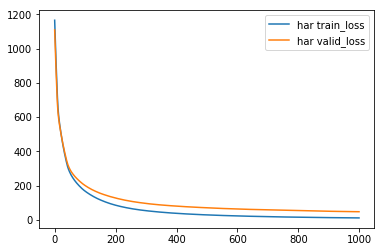

In [50]:
import matplotlib.pyplot as mplot
# % %matplotlib inline
# this is keeping the mpl inline or outline
# inline would inside this block and outline/out of block would be out of this block.
%matplotlib inline

mplot.plot(train_loss, label='har train_loss')
mplot.plot(valid_loss, label='har valid_loss')
mplot.legend()
mplot.show()

In [54]:
test_acc, test_loss = [], []

with tf.Session() as sess:
    # Restore the validated model
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
#     saver.restore(save_path=tf.train.load_checkpoint(ckpt_dir_or_file='checkpoints/cnn-har.ckpt'), sess=sess)
    
    ################## Test
    acc_batch = []
    loss_batch = []    
    # Loop over batches
    for X, Y in get_batches(X=X_test_norm, batch_size=N, y=Y_test_onehot):

        # Feed dictionary
        feed_dict = {inputs_:X, labels_:Y}
        fetches = [cost, accuracy]
        loss, acc = sess.run(feed_dict=feed_dict, fetches=fetches)
        acc_batch.append(acc)
        loss_batch.append(loss)

    test_acc.append(np.mean(acc_batch))
    test_loss.append(np.mean(loss_batch))

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(test_loss)),
          "Test acc: {:.6f}".format(np.mean(test_acc)))

INFO:tensorflow:Restoring parameters from checkpoints/cnn-har.ckpt
Test loss: 66.048729 Test acc: 0.459655
